In [ ]:
!nvidia-smi

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vicent/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

In [2]:
import os
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-04-08


In [5]:
#!pip install sodapy

In [6]:
from sodapy import Socrata

In [7]:
!mkdir data_flow

mkdir: data_flow: File exists


In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [9]:
#Flow

In [10]:
#https://flowmaps.life.bsc.es/flowboard/static/js/mobility.js
province_id_to_name = {'17': 'Girona', '43': 'Tarragona','08': 'Barcelona', '25': 'Lleida'}

In [11]:
#FLOW-Maps end-points

URL_IN_CCAA = "https://flowmaps.life.bsc.es/api/total_incoming_daily_mobility"
URL_OUT_CCAA = "https://flowmaps.life.bsc.es/api/total_outgoing_daily_mobility" 

INCID_CAT = "https://flowmaps.life.bsc.es/api/incidence" 
URL_RISK_CCAA = "https://flowmaps.life.bsc.es/api/incoming_risk_history/"

In [12]:
#Cases

In [13]:
payload = {"where":"{\"ev\":\"ES.covid_cpro\",\"start_date\":\"2020-01-01\",\"end_date\":\"" + today + "\"}"}
response = requests.get(INCID_CAT, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
print(response.url)

#dfCases["date"] = pd.to_datetime(dfCases["date"])
#dfCases.to_csv("data_flow/cases.csv",index=False)

https://flowmaps.life.bsc.es/api/incidence?where=%7B%22ev%22%3A%22ES.covid_cpro%22%2C%22start_date%22%3A%222020-01-01%22%2C%22end_date%22%3A%222021-04-08%22%7D


In [14]:
print(len(response.json()["_items"]))

dfCases = []
for i,row in enumerate(response.json()["_items"]):
    date = row.get("_id")
    
    dfDaily = pd.DataFrame(row.get("data"))

    dfRow = pd.DataFrame(np.array([date, 
     dfDaily.loc[dfDaily["id"]=="08"]["new_cases"].values[0], 
     dfDaily.loc[dfDaily["id"]=="17"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="43"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="25"]["new_cases"].values[0],
    ]).reshape(1,5), columns=["date","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"])
    dfCases.append(dfRow)

dfCases = pd.concat(dfCases)
print(len(dfCases))

463
463


In [15]:
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)
dfCases.to_csv("data_flow/cases_CAT.csv",index=False)

In [16]:
#Risk

In [30]:
dfInRisk=[]
for j,val in enumerate(province_id_to_name.keys()):
    payload = {"where":"{\"target\":\"" + val + "\",\"source_layer\":\"cnig_provincias\",\"target_layer\":\"cnig_provincias\",\"ev\":\"ES.covid_cpro\",\"total\":true}"}
    response = requests.get(URL_RISK_CCAA, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
    print(response.url)
    df = pd.DataFrame(response.json()["_items"])
    print("CCAA:", val,df.shape)
    
    if len(dfInRisk) == 0:
        dfInRisk = df
        dfInRisk["inrisk_"+val] = dfInRisk["incoming_risk"]
        dfInRisk.date = pd.to_datetime(dfInRisk.date)
        dfInRisk = dfInRisk[["date","inrisk_"+val]]
    else:
        df["inrisk_"+val] = df["incoming_risk"]
        df.date = pd.to_datetime(df.date)
        df = df[["date","inrisk_"+val]]
        dfInRisk = pd.merge(dfInRisk,df,on="date",suffixes=('',''))#,left_index=False,right_index=False) 

#Save
dfInRisk.to_csv("data_flow/inrisk_CAT.csv",index=False)

https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2217%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 17 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2243%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 43 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2208%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 08 (398, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2225%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CC

In [19]:
#UCI

#https://analisi.transparenciacatalunya.cat/Salut/Dades-setmanals-de-COVID-19-per-rees-de-gesti-assi/k7cw-sg3w
#https://analisi.transparenciacatalunya.cat/Salut/Dades-di-ries-de-COVID-19-per-comarca/c7sd-zy9j
#https://dev.socrata.com/foundry/analisi.transparenciacatalunya.cat/623z-r97q
#https://dadescovid.cat/static/csv/ingressats_UCI.zip

In [20]:
#public: 3j6279557pu3y7q9eb8q9hfpw
#secret: 2uze9rhfcwodupxz8saonaiy56kmc5updhj5uz3u5kqbfagox6

In [21]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-04-08


In [22]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("c7sd-zy9j",limit=500000) #623z-r97q

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

(152334, 13)


In [31]:
#save
results_df["data"] = pd.to_datetime(results_df["data"])

print(results_df.columns)

results_df["ingressats_critic"] = pd.to_numeric(results_df["ingressats_critic"])
results_df["ingressos_critic"] = pd.to_numeric(results_df["ingressos_critic"])
results_df["ingressats_critic_all"] = results_df["ingressos_critic"]
results_df["ingressats_critic_all"] = pd.to_numeric(results_df["ingressats_critic_all"])

#results_df.sort_values("data",ascending=True).tail()
dfUCI = results_df[["data","ingressats_critic_all"]].groupby("data").sum()
print(dfUCI.columns)
dfUCI["uci"] = dfUCI
dfUCI["date"] = dfUCI.index.values

dfUCI = dfUCI[["date","uci"]]
dfUCI["date"] = pd.to_datetime(dfUCI["date"])
dfUCI.reset_index(drop=True, inplace=True)
dfUCI.to_csv("data_flow/UCI_CAT_" + today +".csv",index=False)

dfUCI.iloc[60:]

Index(['nom', 'codi', 'data', 'sexe', 'grup_edat', 'residencia',
       'casos_confirmat', 'pcr', 'ingressos_total', 'ingressos_critic',
       'ingressats_total', 'ingressats_critic', 'exitus',
       'ingressats_critic_all'],
      dtype='object')
Index(['ingressats_critic_all'], dtype='object')


,date,uci
60,2020-04-30,0
61,2020-05-01,2
62,2020-05-02,4
63,2020-05-03,4
64,2020-05-04,5
...,...,...
398,2021-04-03,31
399,2021-04-04,20
400,2021-04-05,28
401,2021-04-06,45


<AxesSubplot:>

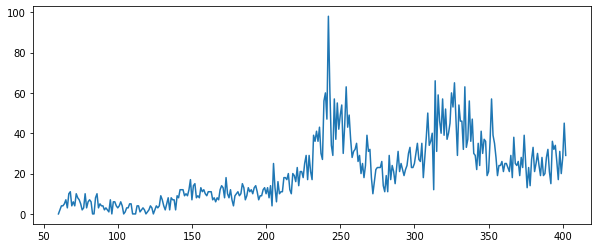

In [32]:
dfUCI.iloc[60:,1].plot(figsize=(10,4))

In [25]:
#Merge, remove null and na imputation

In [26]:
#Risk

In [33]:
today = "2021-04-08" #"2021-01-26"

In [34]:
dfInRisk = pd.read_csv("data_flow/inrisk_CAT_" + today +".csv")

for i,col in enumerate(dfInRisk.columns):
    if i==0:
        dfInRisk[col] = pd.to_datetime(dfInRisk[col])
    else:
        dfInRisk[col] = pd.to_numeric(dfInRisk[col])

dfInRisk.sort_values("date",ascending=True, inplace=True)
dfInRisk["risk_BCN"] = dfInRisk["inrisk_08"]
dfInRisk["risk_GI"] = dfInRisk["inrisk_17"]
dfInRisk["risk_TAR"] = dfInRisk["inrisk_43"]
dfInRisk["risk_LLE"] = dfInRisk["inrisk_25"]
dfInRisk = dfInRisk[["date","risk_BCN","risk_GI","risk_LLE","risk_TAR"]]

print(dfInRisk.shape)
print(dfInRisk.columns)
print(dfInRisk["date"].iloc[:5])

(398, 5)
Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')
0   2020-02-15
1   2020-02-16
2   2020-02-17
3   2020-02-18
4   2020-02-19
Name: date, dtype: datetime64[ns]


In [35]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfInRisk.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInRisk.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInRisk.iloc[i-j,k]
        zn.append(acc/7)

    dfInRisk[cols[k] + "_7"] = zn
    
    #plot
    #plt.figure(figsize=(10,4))    
    #ax = plt.subplot(1,2,1)
    #dfInRisk[["mean"]].plot(ax=ax)
    #ax = plt.subplot(1,2,2)
    #dfInRisk[["mean_7"]].plot(ax=ax)    
    #plt.show()
    #break
    
dfInRisk = dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]]
dfInRisk

Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')


,date,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
0,2020-02-15,0.072949,0.151855,0.043482,0.102327
1,2020-02-16,0.143009,0.275563,0.075502,0.181203
2,2020-02-17,0.209083,0.381742,0.108660,0.260290
3,2020-02-18,0.279912,0.493185,0.143284,0.343318
4,2020-02-19,0.354539,0.602402,0.179170,0.428768
...,...,...,...,...,...
393,2021-03-15,233.164241,139.886954,68.189382,106.805224
394,2021-03-16,236.433578,141.618732,67.897175,107.619623
395,2021-03-17,239.146147,142.808721,67.415143,107.477465
396,2021-03-18,243.235773,144.220018,66.966612,108.520669


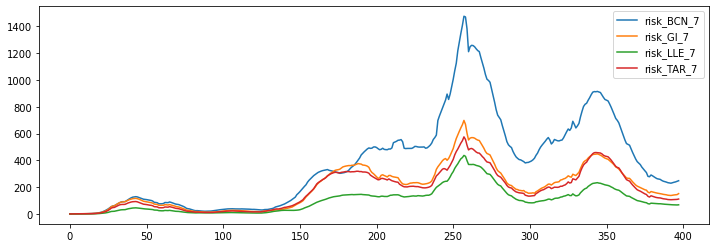

In [36]:
dfInRisk[["risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]].plot(figsize=(12,4))
plt.show()

In [37]:
#Cases

In [38]:
dfCases = pd.read_csv("data_flow/cases_CAT_" + today + ".csv")
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

#Aggregate
dfCases["new_cases"] = np.nansum(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']],axis=1)
#dfCases["new_cases_mean"] = np.nanmean(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_std"] = np.nanstd(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_min"] = np.nanmin(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)
#dfCases["new_cases_max"] = np.nanmax(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']], axis=1)

dfCases = dfCases[["date","new_cases","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]]
dfCases["total_cases"] = np.cumsum(dfCases["new_cases"].values)
print(dfCases.shape,dfCases.columns)

(463, 7) Index(['date', 'new_cases', 'new_cases_BCN', 'new_cases_GI', 'new_cases_TAR',
       'new_cases_LLE', 'total_cases'],
      dtype='object')


In [39]:
cols = dfCases.columns
for k in range(1,len(cols)):
    zn = []
    for i in range(dfCases.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfCases.iloc[i-j,k]
        zn.append(acc/7)

    dfCases[cols[k] + "_7"] = zn

dfCases

,date,new_cases,new_cases_BCN,new_cases_GI,new_cases_TAR,new_cases_LLE,total_cases,new_cases_7,new_cases_BCN_7,new_cases_GI_7,new_cases_TAR_7,new_cases_LLE_7,total_cases_7
0,2020-01-01,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-02,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-01-03,0,0,0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
3,2020-01-04,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
4,2020-01-05,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,2021-04-03,425,318,53,54,71,500669,867.714286,694.142857,120.000000,53.571429,109.428571,498511.714286
459,2021-04-04,288,204,43,41,51,500957,797.857143,641.428571,103.857143,52.571429,102.857143,499309.571429
460,2021-04-05,181,130,29,22,36,501138,636.714286,504.428571,85.571429,46.714286,85.142857,499946.285714
461,2021-04-06,165,127,34,4,6,501303,491.571429,384.857143,67.857143,38.857143,69.285714,500437.857143


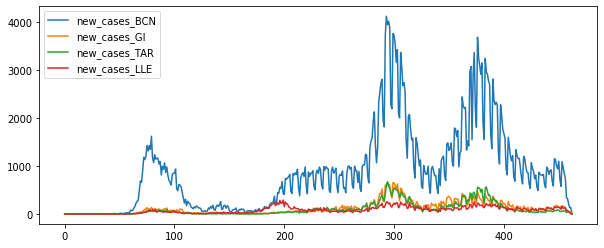

In [40]:
dfCases[["new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]].plot(figsize=(10,4))
plt.show()

Index(['date', 'uci'], dtype='object')


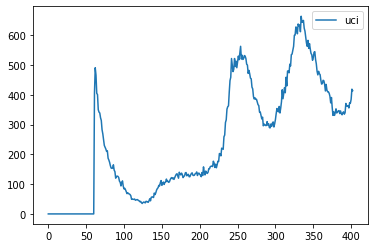

In [41]:
dfUCI = pd.read_csv("data_flow/UCI_CAT_" + today +".csv")
print(dfUCI.columns)
dfUCI.plot()
dfUCI["date"] = pd.to_datetime(dfUCI["date"])

In [42]:
#Merge cases
dfAll = pd.merge(dfCases[["date","new_cases","total_cases","new_cases_7",
                         "new_cases_GI_7","new_cases_LLE_7","new_cases_BCN_7","new_cases_TAR_7"]],
                 dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]], 
                 how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])

#Merge with UCI
dfAll = pd.merge(dfAll, dfUCI, how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])
dfAll["uci"] = pd.to_numeric(dfAll["uci"])

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.iloc[50:150]

(463, 13)
date                0
new_cases           0
total_cases         0
new_cases_7         0
new_cases_GI_7      0
new_cases_LLE_7     0
new_cases_BCN_7     0
new_cases_TAR_7     0
risk_BCN_7         65
risk_GI_7          65
risk_LLE_7         65
risk_TAR_7         65
uci                60
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci
50,2020-02-20,11,70,4.857143,0.000000,0.000000,4.857143,0.000000,0.442276,0.754779,0.225045,0.538895,NaN
51,2020-02-21,17,87,7.142857,0.142857,0.000000,6.857143,0.142857,0.553072,1.005390,0.311428,0.726526,NaN
52,2020-02-22,10,97,6.857143,0.285714,0.142857,6.285714,0.285714,0.612280,1.147988,0.347953,0.845117,NaN
53,2020-02-23,8,105,7.571429,0.428571,0.142857,6.857143,0.285714,0.789293,1.276407,0.383918,0.935209,NaN
54,2020-02-24,10,115,8.857143,0.571429,0.142857,7.857143,0.428571,0.995924,1.403718,0.427314,1.039668,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2020-05-25,206,50957,187.428571,17.714286,24.714286,165.714286,4.000000,34.413628,21.219058,9.969720,18.252280,154.0
146,2020-05-26,197,51154,186.571429,17.714286,23.428571,164.571429,4.285714,35.716813,22.463558,10.206906,19.655537,165.0
147,2020-05-27,145,51299,181.428571,17.857143,23.142857,159.571429,4.000000,36.723027,23.799491,10.340238,20.536192,147.0
148,2020-05-28,197,51496,178.142857,18.142857,23.142857,156.857143,3.142857,37.531106,24.906303,10.433040,21.192392,142.0


In [43]:
#Remove days without mobility index 
dfAll = dfAll.iloc[121:]

#Remove last day 
dfAll = dfAll.iloc[:-3]

dfAll.reset_index(inplace=True, drop=True)
#Na inputation
#dfAll.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True, order=2)

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.tail()

(339, 13)
date                0
new_cases           0
total_cases         0
new_cases_7         0
new_cases_GI_7      0
new_cases_LLE_7     0
new_cases_BCN_7     0
new_cases_TAR_7     0
risk_BCN_7         17
risk_GI_7          17
risk_LLE_7         17
risk_TAR_7         17
uci                 0
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7,uci
334,2021-03-31,1062,498924,1102.714286,148.285714,130.428571,889.714286,64.714286,NaN,NaN,NaN,NaN,362.0
335,2021-04-01,906,499830,1063.714286,142.571429,127.571429,860.428571,60.714286,NaN,NaN,NaN,NaN,364.0
336,2021-04-02,414,500244,935.714286,130.285714,117.142857,752.142857,53.285714,NaN,NaN,NaN,NaN,356.0
337,2021-04-03,425,500669,867.714286,120.000000,109.428571,694.142857,53.571429,NaN,NaN,NaN,NaN,373.0
338,2021-04-04,288,500957,797.857143,103.857143,102.857143,641.428571,52.571429,NaN,NaN,NaN,NaN,372.0


(270, 308)
Index(['var1(t-7)', 'var2(t-7)', 'var3(t-7)', 'var4(t-7)', 'var5(t-7)',
       'var6(t-7)', 'var7(t-7)', 'var8(t-7)', 'var9(t-7)', 'var10(t-7)',
       ...
       'var2(t+20)', 'var3(t+20)', 'var4(t+20)', 'var5(t+20)', 'var6(t+20)',
       'var7(t+20)', 'var8(t+20)', 'var9(t+20)', 'var10(t+20)', 'var11(t+20)'],
      dtype='object', length=308)
249


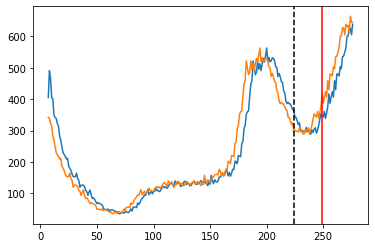

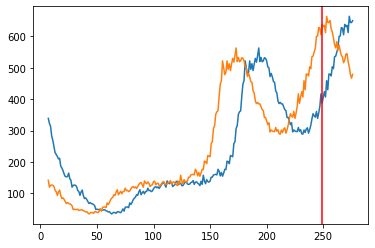

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var1(t-6)
7,182.0,161.285714,16.000000,6.857143,138.428571,7.142857,41.876176,28.807612,10.571563,21.095206,406.0,151.0
8,151.0,159.000000,17.000000,7.000000,135.000000,5.571429,39.040574,26.829692,10.105683,19.853962,491.0,139.0
9,139.0,159.571429,18.142857,6.857143,134.571429,5.000000,37.244670,25.598871,9.889896,19.233568,466.0,123.0
10,123.0,158.285714,17.428571,6.000000,134.857143,6.571429,33.359676,22.921110,9.345337,17.380033,405.0,68.0
11,68.0,142.857143,14.571429,6.285714,122.000000,6.285714,29.747482,20.915490,8.761977,15.776791,401.0,55.0


In [44]:
#Convert data to format (rows,timepoints,features)
cols = [
         #'total_cases',
         'new_cases',
         'new_cases_7',
         'new_cases_GI_7',
         'new_cases_TAR_7',
         'new_cases_BCN_7',
         'new_cases_LLE_7',    
         'risk_BCN_7',
         'risk_GI_7',
         'risk_LLE_7',
         'risk_TAR_7',
         'uci'
]
res = series_to_supervised(dfAll.loc[:,cols].values,7,21)
print(res.shape)
print(res.columns)

THR_TEST = 21 # 21 #days to test
THR = res.shape[0]-THR_TEST
print(THR)

plt.plot(res[["var11(t-7)","var11(t-1)"]])
plt.axvline(THR,c="r")
plt.axvline(int(THR-(THR*0.10)),c="black", ls="--")
plt.show()

plt.plot(res[["var11(t)"]])
plt.plot(res[["var11(t+20)"]])
plt.axvline(THR,c="r")
plt.show()

res.iloc[:,:12].head()

In [45]:
print([87+(11*i) for i in range(21)])
res.iloc[:5,[10,76,87,98]]

[87, 98, 109, 120, 131, 142, 153, 164, 175, 186, 197, 208, 219, 230, 241, 252, 263, 274, 285, 296, 307]


,var11(t-7),var11(t-1),var11(t),var11(t+1)
7,406.0,342.0,339.0,323.0
8,491.0,339.0,323.0,314.0
9,466.0,323.0,314.0,283.0
10,405.0,314.0,283.0,269.0
11,401.0,283.0,269.0,249.0


In [46]:
#Patition train/test
train_X = res.iloc[:THR,:77].values.reshape(-1,7,11)
train_y = res.iloc[:THR,[87+(11*i) for i in range(21)]].values.reshape(-1,21)
test_X = res.iloc[THR:,:77].values.reshape(-1,7,11)
test_y = res.iloc[THR:,[87+(11*i) for i in range(21)]].values.reshape(-1,21)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(249, 7, 11) (249, 21) (21, 7, 11) (21, 21)


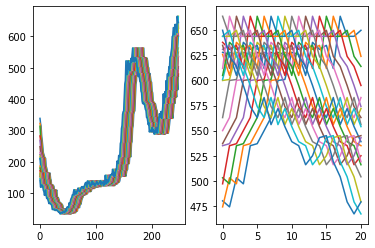

In [47]:
ax=plt.subplot(1,2,1)
ax.plot(range(len(train_y)),train_y)
ax=plt.subplot(1,2,2)
ax.plot(range(len(test_y)),test_y)
plt.show()

In [48]:
# normalize features
scalers_X = []
for i in range(train_X.shape[-1]):

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
    test_X[:,:,i] = scaler.transform(test_X[:,:,i])
    scalers_X.append(scaler)
    
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1,21))
test_y = scaler_y.transform(test_y.reshape(-1,21))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(249, 7, 11) (249, 21) (21, 7, 11) (21, 21)


In [49]:
scaler_y.inverse_transform(train_y)[:5]

array([[339., 323., 314., 283., 269., 249., 230., 224., 218., 210., 212.,
        187., 181., 173., 162., 154., 153., 154., 165., 147., 142.],
       [323., 314., 283., 269., 249., 230., 224., 218., 210., 212., 187.,
        181., 173., 162., 154., 153., 154., 165., 147., 142., 120.],
       [314., 283., 269., 249., 230., 224., 218., 210., 212., 187., 181.,
        173., 162., 154., 153., 154., 165., 147., 142., 120., 126.],
       [283., 269., 249., 230., 224., 218., 210., 212., 187., 181., 173.,
        162., 154., 153., 154., 165., 147., 142., 120., 126., 127.],
       [269., 249., 230., 224., 218., 210., 212., 187., 181., 173., 162.,
        154., 153., 154., 165., 147., 142., 120., 126., 127., 126.]])

In [50]:
fname = "best_model_uci_CAT_7to21ahead_1"

In [51]:
#Model

In [52]:
# fit network
bs=4
history=[]
min_tr = []
min_val = []
for i in range(10):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(100, activation="relu",
                                input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_dropout=0.1))
                                #return_sequences=True))                            
    #model.add(keras.layers.LSTM(50))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(21))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=["mae"])
    
    # design callbacks
    es = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', 
                                       verbose=1, patience=50)
    mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                         monitor='val_mean_absolute_error', 
                                         verbose=1, save_best_only=True)

    history.append(model.fit(train_X, train_y, epochs=500, batch_size=bs, 
                        callbacks=[es,mc],validation_split=0.10, verbose=0, shuffle=False))
    
    ix = np.argmin(history[-1].history.get('val_mean_absolute_error'))
    min_val.append(history[-1].history.get('val_mean_absolute_error')[ix])
    min_tr.append(history[-1].history.get('mean_absolute_error')[ix])

print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
print("MIN VAL:",np.mean(min_val),np.std(min_val))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: val_mean_absolute_error improved from inf to 0.50856, saving model to models/best_model_uci_CAT_7to21ahead_1_0.h5

Epoch 00002: val_mean_absolute_error improved from 0.50856 to 0.19902, saving model to models/best_model_uci_CAT_7to21ahead_1_0.h5

Epoch 00003: val_mean_absolute_error did not improve from 0.19902

Epoch 00004: val_mean_absolute_error did not improve from 0.19902

Epoch 00005: val_mean_absolute_error did not improve from 0.19902

Epoch 00006: val_mean_absolute_error did not improve from 0.19902

Epoch 00007: val_mean_absolute_error did not improve from 0.19902

Epoch 00008: val_mean_absolute_error did not improve from 0.19902

Epoch 00009: val_mean_absolute_error did not improve from 0.19902

Epoch 00010: val_mean_absolute_error did not improve from 0.19902

Epoch 00011: val_mean_absolute_error did not improve from 0.19902

Epoch 00012: val_mean_absolute_error improved from 0.19902 to 0.18550, saving model to models/best_model_uci_CAT_7to21ahead_1_0.h5

Epoc


Epoch 00109: val_mean_absolute_error did not improve from 0.06352

Epoch 00110: val_mean_absolute_error did not improve from 0.06352

Epoch 00111: val_mean_absolute_error did not improve from 0.06352

Epoch 00112: val_mean_absolute_error did not improve from 0.06352

Epoch 00113: val_mean_absolute_error did not improve from 0.06352

Epoch 00114: val_mean_absolute_error did not improve from 0.06352

Epoch 00115: val_mean_absolute_error did not improve from 0.06352

Epoch 00116: val_mean_absolute_error did not improve from 0.06352

Epoch 00117: val_mean_absolute_error did not improve from 0.06352

Epoch 00118: val_mean_absolute_error did not improve from 0.06352

Epoch 00119: val_mean_absolute_error did not improve from 0.06352

Epoch 00120: val_mean_absolute_error did not improve from 0.06352

Epoch 00121: val_mean_absolute_error did not improve from 0.06352

Epoch 00122: val_mean_absolute_error did not improve from 0.06352

Epoch 00123: val_mean_absolute_error did not improve from 0.0


Epoch 00093: val_mean_absolute_error did not improve from 0.06753

Epoch 00094: val_mean_absolute_error did not improve from 0.06753

Epoch 00095: val_mean_absolute_error did not improve from 0.06753

Epoch 00096: val_mean_absolute_error did not improve from 0.06753

Epoch 00097: val_mean_absolute_error did not improve from 0.06753

Epoch 00098: val_mean_absolute_error did not improve from 0.06753

Epoch 00099: val_mean_absolute_error did not improve from 0.06753

Epoch 00100: val_mean_absolute_error did not improve from 0.06753

Epoch 00101: val_mean_absolute_error did not improve from 0.06753

Epoch 00102: val_mean_absolute_error did not improve from 0.06753

Epoch 00103: val_mean_absolute_error did not improve from 0.06753

Epoch 00104: val_mean_absolute_error did not improve from 0.06753

Epoch 00105: val_mean_absolute_error did not improve from 0.06753

Epoch 00106: val_mean_absolute_error did not improve from 0.06753

Epoch 00107: val_mean_absolute_error did not improve from 0.0


Epoch 00069: val_mean_absolute_error did not improve from 0.06664

Epoch 00070: val_mean_absolute_error did not improve from 0.06664

Epoch 00071: val_mean_absolute_error did not improve from 0.06664

Epoch 00072: val_mean_absolute_error did not improve from 0.06664

Epoch 00073: val_mean_absolute_error did not improve from 0.06664

Epoch 00074: val_mean_absolute_error did not improve from 0.06664

Epoch 00075: val_mean_absolute_error did not improve from 0.06664

Epoch 00076: val_mean_absolute_error did not improve from 0.06664

Epoch 00077: val_mean_absolute_error did not improve from 0.06664

Epoch 00078: val_mean_absolute_error did not improve from 0.06664

Epoch 00079: val_mean_absolute_error did not improve from 0.06664

Epoch 00080: val_mean_absolute_error did not improve from 0.06664

Epoch 00081: val_mean_absolute_error did not improve from 0.06664

Epoch 00082: val_mean_absolute_error did not improve from 0.06664

Epoch 00083: val_mean_absolute_error did not improve from 0.0


Epoch 00068: val_mean_absolute_error did not improve from 0.06088

Epoch 00069: val_mean_absolute_error did not improve from 0.06088

Epoch 00070: val_mean_absolute_error did not improve from 0.06088

Epoch 00071: val_mean_absolute_error did not improve from 0.06088

Epoch 00072: val_mean_absolute_error did not improve from 0.06088

Epoch 00073: val_mean_absolute_error did not improve from 0.06088

Epoch 00074: val_mean_absolute_error did not improve from 0.06088

Epoch 00075: val_mean_absolute_error did not improve from 0.06088

Epoch 00076: val_mean_absolute_error did not improve from 0.06088

Epoch 00077: val_mean_absolute_error did not improve from 0.06088

Epoch 00078: val_mean_absolute_error did not improve from 0.06088

Epoch 00079: val_mean_absolute_error did not improve from 0.06088

Epoch 00080: val_mean_absolute_error did not improve from 0.06088

Epoch 00081: val_mean_absolute_error did not improve from 0.06088

Epoch 00082: val_mean_absolute_error did not improve from 0.0


Epoch 00087: val_mean_absolute_error did not improve from 0.05694

Epoch 00088: val_mean_absolute_error did not improve from 0.05694

Epoch 00089: val_mean_absolute_error did not improve from 0.05694

Epoch 00090: val_mean_absolute_error did not improve from 0.05694

Epoch 00091: val_mean_absolute_error did not improve from 0.05694

Epoch 00092: val_mean_absolute_error did not improve from 0.05694

Epoch 00093: val_mean_absolute_error did not improve from 0.05694

Epoch 00094: val_mean_absolute_error did not improve from 0.05694

Epoch 00095: val_mean_absolute_error did not improve from 0.05694

Epoch 00096: val_mean_absolute_error did not improve from 0.05694

Epoch 00097: val_mean_absolute_error did not improve from 0.05694

Epoch 00098: val_mean_absolute_error did not improve from 0.05694

Epoch 00099: val_mean_absolute_error did not improve from 0.05694

Epoch 00100: val_mean_absolute_error did not improve from 0.05694

Epoch 00101: val_mean_absolute_error did not improve from 0.0


Epoch 00090: val_mean_absolute_error did not improve from 0.05830

Epoch 00091: val_mean_absolute_error did not improve from 0.05830

Epoch 00092: val_mean_absolute_error did not improve from 0.05830

Epoch 00093: val_mean_absolute_error did not improve from 0.05830

Epoch 00094: val_mean_absolute_error did not improve from 0.05830

Epoch 00095: val_mean_absolute_error did not improve from 0.05830

Epoch 00096: val_mean_absolute_error did not improve from 0.05830

Epoch 00097: val_mean_absolute_error did not improve from 0.05830

Epoch 00098: val_mean_absolute_error did not improve from 0.05830

Epoch 00099: val_mean_absolute_error did not improve from 0.05830

Epoch 00100: val_mean_absolute_error did not improve from 0.05830

Epoch 00101: val_mean_absolute_error did not improve from 0.05830

Epoch 00102: val_mean_absolute_error did not improve from 0.05830

Epoch 00103: val_mean_absolute_error did not improve from 0.05830

Epoch 00104: val_mean_absolute_error did not improve from 0.0


Epoch 00063: val_mean_absolute_error did not improve from 0.05530

Epoch 00064: val_mean_absolute_error did not improve from 0.05530

Epoch 00065: val_mean_absolute_error did not improve from 0.05530

Epoch 00066: val_mean_absolute_error did not improve from 0.05530

Epoch 00067: val_mean_absolute_error did not improve from 0.05530

Epoch 00068: val_mean_absolute_error did not improve from 0.05530

Epoch 00069: val_mean_absolute_error did not improve from 0.05530

Epoch 00070: val_mean_absolute_error did not improve from 0.05530

Epoch 00071: val_mean_absolute_error did not improve from 0.05530

Epoch 00072: val_mean_absolute_error did not improve from 0.05530

Epoch 00073: val_mean_absolute_error did not improve from 0.05530

Epoch 00074: val_mean_absolute_error did not improve from 0.05530

Epoch 00075: val_mean_absolute_error did not improve from 0.05530

Epoch 00076: val_mean_absolute_error did not improve from 0.05530

Epoch 00077: val_mean_absolute_error did not improve from 0.0


Epoch 00084: val_mean_absolute_error did not improve from 0.06888

Epoch 00085: val_mean_absolute_error did not improve from 0.06888

Epoch 00086: val_mean_absolute_error did not improve from 0.06888

Epoch 00087: val_mean_absolute_error did not improve from 0.06888

Epoch 00088: val_mean_absolute_error did not improve from 0.06888

Epoch 00089: val_mean_absolute_error did not improve from 0.06888

Epoch 00090: val_mean_absolute_error did not improve from 0.06888

Epoch 00091: val_mean_absolute_error did not improve from 0.06888

Epoch 00092: val_mean_absolute_error did not improve from 0.06888
Epoch 00092: early stopping

Epoch 00001: val_mean_absolute_error improved from inf to 0.52323, saving model to models/best_model_uci_CAT_7to21ahead_1_8.h5

Epoch 00002: val_mean_absolute_error improved from 0.52323 to 0.20636, saving model to models/best_model_uci_CAT_7to21ahead_1_8.h5

Epoch 00003: val_mean_absolute_error did not improve from 0.20636

Epoch 00004: val_mean_absolute_error did 


Epoch 00098: val_mean_absolute_error did not improve from 0.06489

Epoch 00099: val_mean_absolute_error did not improve from 0.06489

Epoch 00100: val_mean_absolute_error did not improve from 0.06489

Epoch 00101: val_mean_absolute_error did not improve from 0.06489

Epoch 00102: val_mean_absolute_error did not improve from 0.06489

Epoch 00103: val_mean_absolute_error did not improve from 0.06489

Epoch 00104: val_mean_absolute_error did not improve from 0.06489

Epoch 00105: val_mean_absolute_error did not improve from 0.06489

Epoch 00106: val_mean_absolute_error did not improve from 0.06489

Epoch 00107: val_mean_absolute_error did not improve from 0.06489

Epoch 00108: val_mean_absolute_error did not improve from 0.06489

Epoch 00109: val_mean_absolute_error did not improve from 0.06489

Epoch 00110: val_mean_absolute_error did not improve from 0.06489

Epoch 00111: val_mean_absolute_error did not improve from 0.06489

Epoch 00112: val_mean_absolute_error did not improve from 0.0


Epoch 00095: val_mean_absolute_error did not improve from 0.05534

Epoch 00096: val_mean_absolute_error did not improve from 0.05534

Epoch 00097: val_mean_absolute_error did not improve from 0.05534

Epoch 00098: val_mean_absolute_error did not improve from 0.05534

Epoch 00099: val_mean_absolute_error did not improve from 0.05534

Epoch 00100: val_mean_absolute_error did not improve from 0.05534
Epoch 00100: early stopping

MIN TR: 0.04538998 0.004477026
MIN VAL: 0.06182418 0.004895677


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
MAE VALSET: 0 0.06352169
MAE VALSET: 1 0.06753451
MAE VALSET: 2 0.066643804
MAE VALSET: 3 0.0608846
MAE VALSET: 4 0.056942075
MAE VALSET: 5 0.05830499
MAE VALSET: 6 0.055300053
MAE VALSET: 7 0.06887917
MAE VALSET: 8 0.06489457
MAE VALSET: 9 0.055336386
MAE VALSE (MEAN): 0.06182418


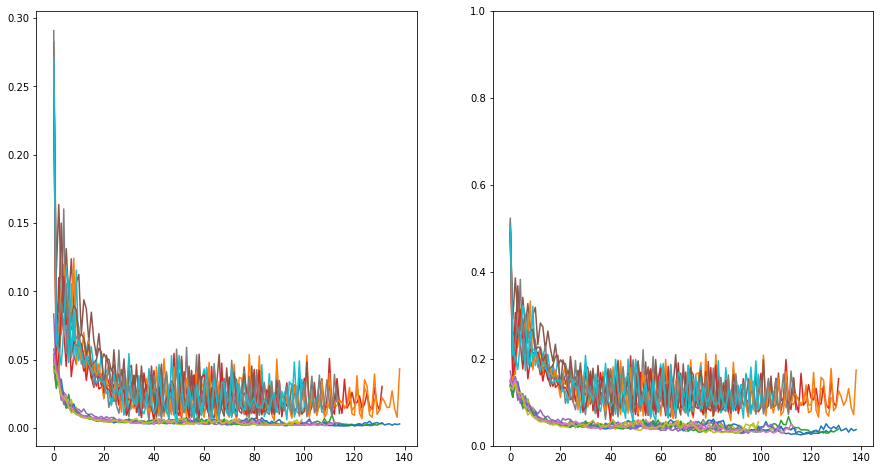

In [53]:
# plot history
plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1)

print(history[0].history.keys())

mins = []
for i in range(len(history)):
    mins.append(np.min(history[i].history.get('val_mean_absolute_error')))
    print("MAE VALSET:", i,np.min(history[i].history.get('val_mean_absolute_error')))
    ax.plot(history[i].history['loss'], label='train')
    ax.plot(history[i].history['val_loss'], label='test')
print("MAE VALSE (MEAN):", np.mean(mins))

ax = plt.subplot(1,2,2)
for i in range(len(history)):
    ax.plot(history[i].history['mean_absolute_error'], label='train')
    ax.plot(history[i].history['val_mean_absolute_error'], label='test')
plt.ylim(0,1.)
plt.show()

#0.0605

In [54]:
print("Loading...", fname)
model = tf.keras.models.load_model("models/"+ fname + "_" + str(4) +'.h5')

Loading... best_model_uci_CAT_7to21ahead_1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [55]:
#retrain
#history = model.fit(train_X[278:,:,:], train_y[278:], epochs=5, batch_size=bs, 
#                    verbose=1, shuffle=False)

(249, 21)
(249, 21)


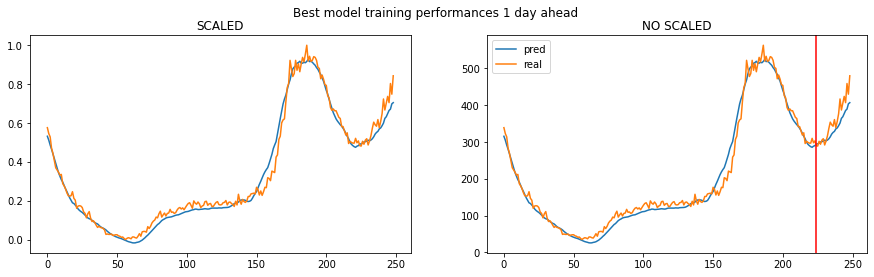

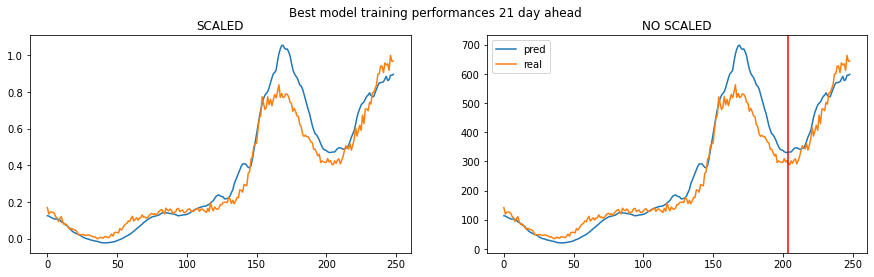

In [56]:
tr = model.predict(train_X)
print(tr.shape)
tr_y_pred = scaler_y.inverse_transform(tr)
tr_y_real = scaler_y.inverse_transform(train_y)
print(tr_y_real.shape)

for i in [0,20]:
    fig = plt.figure(figsize=(15,4))
    ax = plt.subplot(1,2,1)
    ax.plot(range(len(tr)),tr[:,i], label="pred")
    ax.plot(range(len(tr)),train_y[:,i],label="real")
    ax.set_title("SCALED")
    ax = plt.subplot(1,2,2)
    ax.plot(range(len(tr)),tr_y_pred[:,i], label="pred")
    ax.plot(range(len(tr)),tr_y_real[:,i],label="real")
    ax.set_title("NO SCALED")
    ax.axvline(int(THR-(THR*0.1)-i),c="r")
    plt.legend()
    plt.suptitle("Best model training performances {} day ahead".format(i+1))
    plt.show()

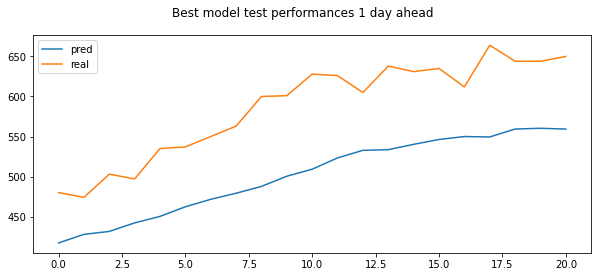

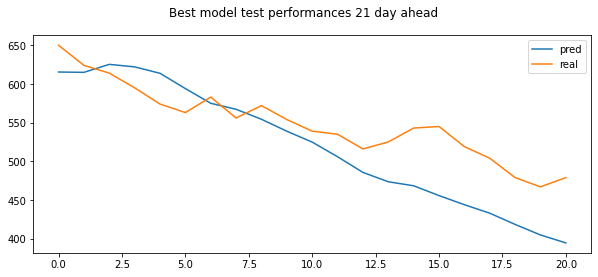

In [57]:
ts = model.predict(test_X)
ts_y_pred = scaler_y.inverse_transform(ts)
ts_y_real = scaler_y.inverse_transform(test_y)

for i in [0,20]:
    plt.figure(figsize=(10,4))
    ax = plt.subplot(1,1,1)
    ax.plot(range(len(ts_y_pred)),ts_y_pred[:,i], label="pred")
    ax.plot(range(len(ts_y_real)),ts_y_real[:,i],label="real")
    plt.suptitle("Best model test performances {} day ahead".format(i+1))
    plt.legend()
    plt.show()

In [58]:
from sklearn import metrics
print(tr_y_pred.shape, ts_y_pred.shape)
maes = []
for i in range(21):
    maes.append(metrics.mean_absolute_error(ts_y_real[:,i], ts_y_pred[:,i]))
    print("Forecast:", i, "day")
    print('Test mean absolute error (mae): {}'.format(maes[-1]))
    if i == 20:
        print('Test r^2: {}'.format(metrics.r2_score(ts_y_real[:,i], ts_y_pred[:,i])))

(249, 21) (21, 21)
Forecast: 0 day
Test mean absolute error (mae): 84.93287150065106
Forecast: 1 day
Test mean absolute error (mae): 56.12999471028648
Forecast: 2 day
Test mean absolute error (mae): 76.14951578776044
Forecast: 3 day
Test mean absolute error (mae): 78.45286487397695
Forecast: 4 day
Test mean absolute error (mae): 58.87399291992192
Forecast: 5 day
Test mean absolute error (mae): 62.88778395879841
Forecast: 6 day
Test mean absolute error (mae): 50.54812186104916
Forecast: 7 day
Test mean absolute error (mae): 57.96459379650302
Forecast: 8 day
Test mean absolute error (mae): 64.32747105189736
Forecast: 9 day
Test mean absolute error (mae): 69.4389401390439
Forecast: 10 day
Test mean absolute error (mae): 65.86603219168528
Forecast: 11 day
Test mean absolute error (mae): 59.33289010184154
Forecast: 12 day
Test mean absolute error (mae): 31.030039469401057
Forecast: 13 day
Test mean absolute error (mae): 44.577575683593764
Forecast: 14 day
Test mean absolute error (mae): 50.

In [59]:
print("Avg (daily) maes:", np.mean(maes))

Avg (daily) maes: 54.753432431729216


In [60]:
#Cumulative


Cumulative prediction at: 0 day ahead
Incremento de casos en el período: 11837.0
Incremento predicho en el período: 10116.3125
Diferencia de casos entre real y modelo en el período: 1720.6875
Risk ratio pred vs real: 0.8546348314606742
Risk ratio real vs pred: 1.170090386195563

Cumulative prediction at: 1 day ahead
Incremento de casos en el período: 11987.0
Incremento predicho en el período: 10820.109375
Diferencia de casos entre real y modelo en el período: 1166.890625
Risk ratio pred vs real: 0.9026536560440477
Risk ratio real vs pred: 1.107844623797992

Cumulative prediction at: 2 day ahead
Incremento de casos en el período: 12098.0
Incremento predicho en el período: 10551.95703125
Diferencia de casos entre real y modelo en el período: 1546.04296875
Risk ratio pred vs real: 0.8722067309679286
Risk ratio real vs pred: 1.146517178204132

Cumulative prediction at: 3 day ahead
Incremento de casos en el período: 12196.0
Incremento predicho en el período: 10578.6171875
Diferencia de cas

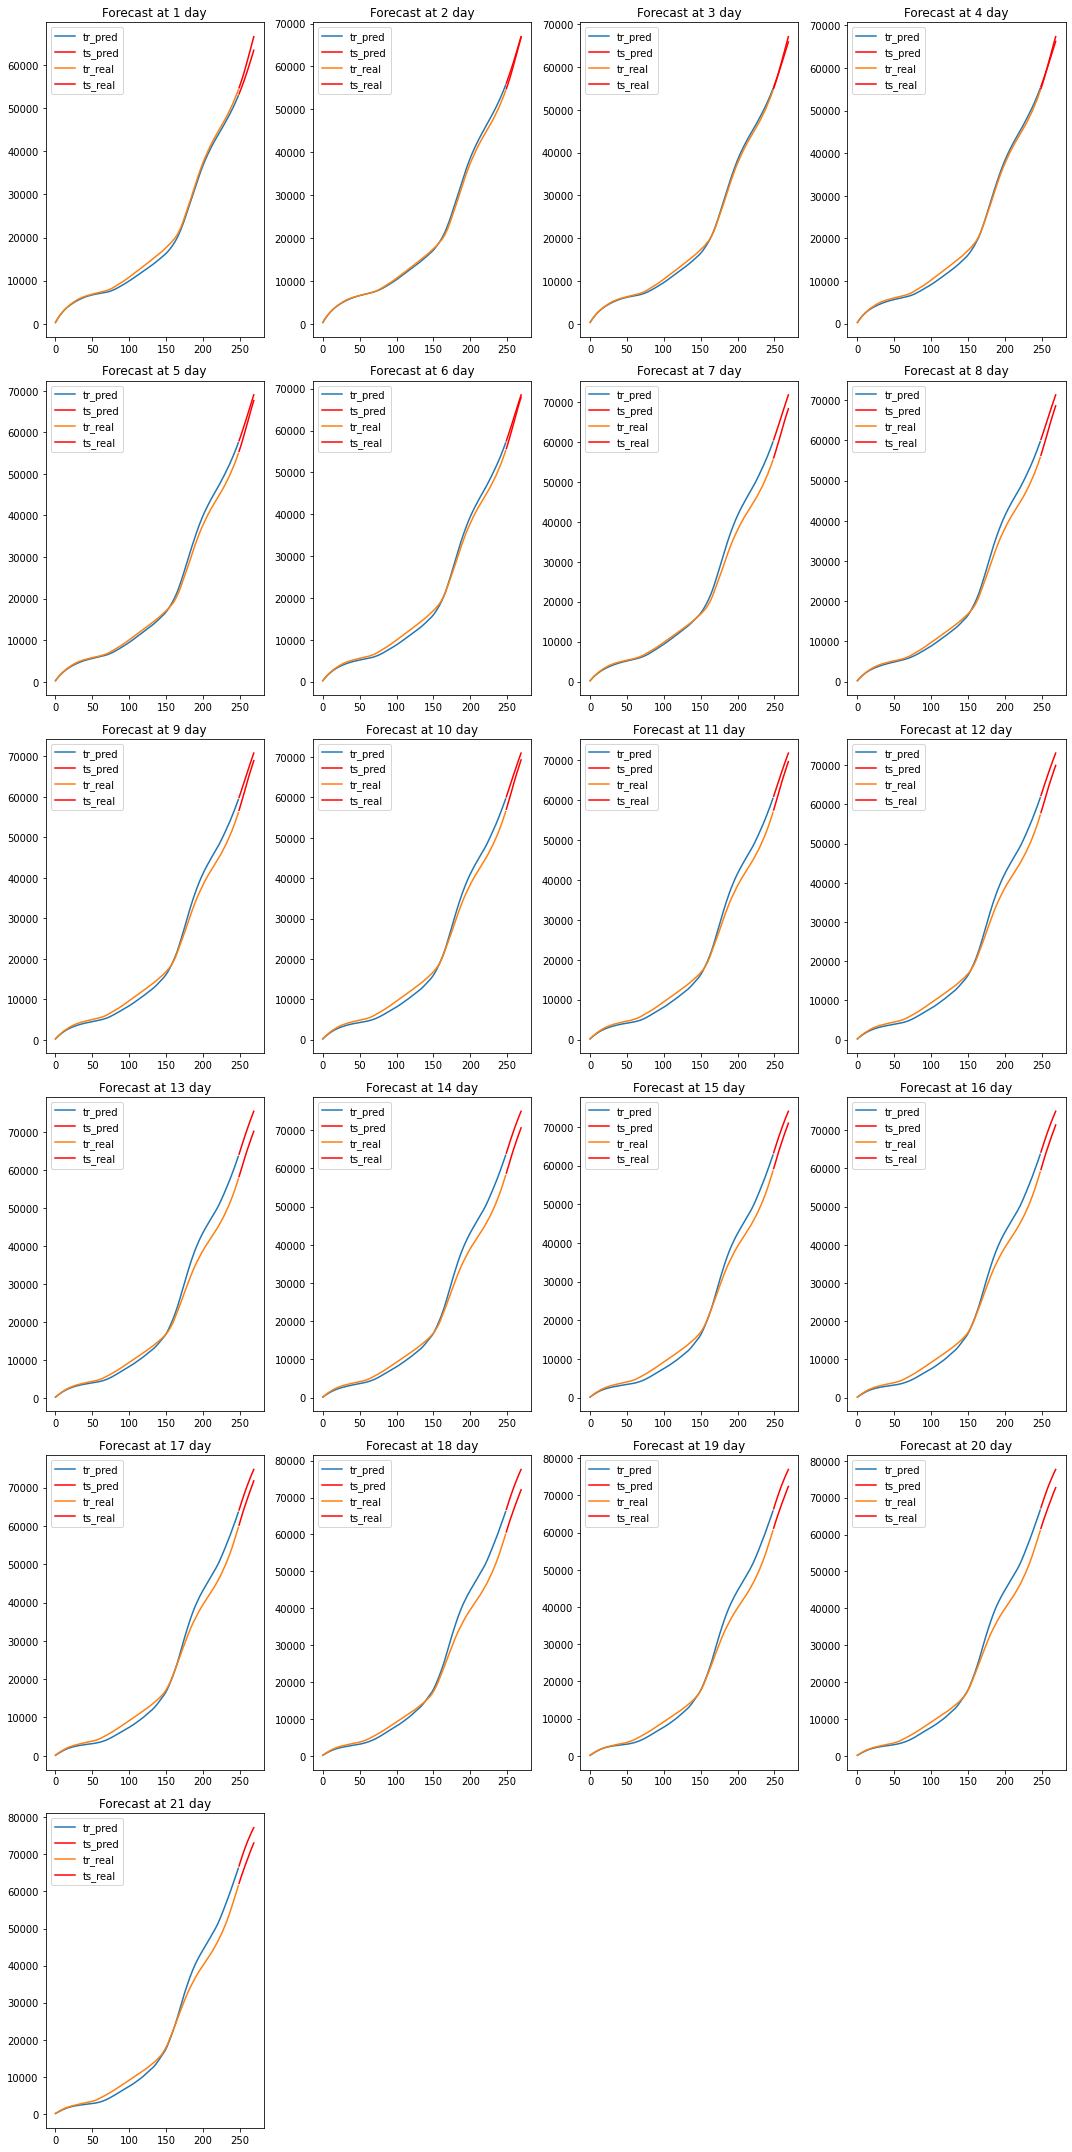

In [61]:
err_diffs = []
err_prs = []
err_rps = []

plt.figure(figsize=(15,30))
for i in range(21):
    
    y_pred = np.concatenate([tr_y_pred[:,i], ts_y_pred[:,i]])
    y_cum_pred = np.cumsum(y_pred)

    y_real = np.concatenate([tr_y_real[:,i], ts_y_real[:,i]])
    y_cum_real = np.cumsum(y_real)
    

    contador_pred = y_cum_pred[-1] - y_cum_pred[len(tr_y_pred)]
    err_diff = y_cum_real[-1] - y_cum_real[len(tr_y_pred)]- contador_pred
    
    print("\nCumulative prediction at:", i, "day ahead")
    print("Incremento de casos en el período: {}".format(y_cum_real[-1] - y_cum_real[len(tr_y_pred)]))
    print("Incremento predicho en el período: {}".format(y_cum_pred[-1] - y_cum_pred[len(tr_y_pred)]))
    print("Diferencia de casos entre real y modelo en el período: {}".format(err_diff))  
    
    err_pr = contador_pred / (y_cum_real[-1] - y_cum_real[len(tr_y_pred)])
    err_rp = (y_cum_real[-1] - y_cum_real[len(tr_y_pred)])/contador_pred
    print("Risk ratio pred vs real:", err_pr)
    print("Risk ratio real vs pred:", err_rp)
    
    err_diffs.append(err_diff)
    err_prs.append(err_pr)
    err_rps.append(err_rp)
    
    ax = plt.subplot(6,4,i+1)
    ax.plot(range(len(tr_y_pred)), y_cum_pred[:len(tr_y_pred)],label="tr_pred")
    ax.plot(range(len(tr_y_pred),len(tr_y_pred)+len(ts_y_pred)), y_cum_pred[len(tr_y_pred):], c="red",label="ts_pred")
    ax.plot(range(len(tr_y_real)), y_cum_real[:len(tr_y_pred)],label="tr_real")
    ax.plot(range(len(tr_y_real),len(tr_y_real)+len(ts_y_real)), y_cum_real[len(tr_y_pred):], c="red",label="ts_real")
    ax.set_title("Forecast at "+str(i+1)+ " day")
    ax.legend()

plt.tight_layout()
plt.show()

In [62]:
print("Daily cumulative diff error (in 21 days period):", np.mean(err_diffs),"+/-",np.std(err_diffs))
print("Daily cumulative pred/real ratio error (in 21 days period):", np.mean(err_prs),"+/-",np.std(err_prs))

Daily cumulative diff error (in 21 days period): 1090.885044642857 +/- 330.22153372976345
Daily cumulative pred/real ratio error (in 21 days period): 0.9086457345964195 +/- 0.026001694642864233


In [63]:
#Forecasting future!!

In [64]:
res_test = series_to_supervised(dfAll.loc[:,cols].values,7,21,dropnan=False)
print(cols)
res_test.shape

['new_cases', 'new_cases_7', 'new_cases_GI_7', 'new_cases_TAR_7', 'new_cases_BCN_7', 'new_cases_LLE_7', 'risk_BCN_7', 'risk_GI_7', 'risk_LLE_7', 'risk_TAR_7', 'uci']


(339, 308)

In [65]:
#Find rows for future pred
ftest_X = res_test.iloc[-1,:77].values.reshape(-1,7,11)
ftest_y = res_test.iloc[-1,[87+(11*i) for i in range(21)]].values.reshape(-1,21)

print(ftest_X.shape, ftest_y.shape)
print(ftest_y[0,:])

(1, 7, 11) (1, 21)
[372.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan]


In [66]:
# normalize features
for i in range(ftest_X.shape[-1]):

    # normalize features
    ftest_X[:,:,i] = scalers_X[i].transform(ftest_X[:,:,i])

print(ftest_X.shape)
print(np.max(ftest_X),np.min(ftest_X),np.mean(ftest_X),np.std(ftest_X))

(1, 7, 11)
nan nan nan nan


In [67]:
#Forecasting with single model

Forecast: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]


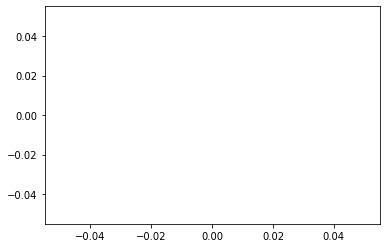

In [68]:
fts = model.predict(ftest_X)
fts = scaler_y.inverse_transform(fts)[0]
print("Forecast:", fts)

plt.plot(range(len(fts)), fts)
plt.show()

In [69]:
#Forecasting last X days for all models

In [70]:
all_preds = []
for i in range(10):
    print("\nLoading model:", i)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(i) +'.h5')
    preds = model.predict(ftest_X)
    preds_inv = scaler_y.inverse_transform(preds)
    print(len(preds_inv), np.max(preds_inv), np.min(preds_inv))
    print(preds_inv.shape)
    all_preds.append(preds_inv)


Loading model: 0
1 nan nan
(1, 21)

Loading model: 1
1 nan nan
(1, 21)

Loading model: 2
1 nan nan
(1, 21)

Loading model: 3
1 nan nan
(1, 21)

Loading model: 4
1 nan nan
(1, 21)

Loading model: 5
1 nan nan
(1, 21)

Loading model: 6
1 nan nan
(1, 21)

Loading model: 7
1 nan nan
(1, 21)

Loading model: 8
1 nan nan
(1, 21)

Loading model: 9
1 nan nan
(1, 21)


In [71]:
all_preds_aux = np.stack((all_preds))
print(all_preds_aux.shape)

all_preds_aux[:,-1,:].mean(axis=0)
all_preds_aux[:,-1,:].std(axis=0)

(10, 1, 21)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [72]:
all_res = all_preds_aux[:,:all_preds_aux.shape[1]]
for i in range(all_preds_aux.shape[1]-1,19,-1):
    all_res = np.hstack((all_preds_aux[:,i,-1].reshape(10,1),all_res))

all_res = np.array(all_res)
print(all_res.shape)

(10, 1, 21)


In [73]:
dfPreds = pd.DataFrame(np.hstack((all_res)).astype(int).reshape(10,21),
                       columns=["d"+str(i) for i in range(21)])
dfPreds.astype(int).to_csv("preds_icu_21days_7tp_"+today+".csv",index=False)
dfPreds.describe().T

,count,mean,std,min,25%,50%,75%,max
d0,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d1,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d2,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d3,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d4,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d5,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d6,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d7,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d8,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18
d9,10.0,-9.223372e+18,0.0,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18,-9.223372e+18


In [ ]:
import datetime
import matplotlib.dates as mdates
date_time_str = '2021-01-30'
base = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
date_list = [base + datetime.timedelta(days=x) for x in range(21)]
date_list

In [ ]:
dfPredsT = dfPreds.T
dfPredsT.reset_index(drop=True, inplace=True)
dfPredsT["date"] = date_list
#dfPredsT["date"] = pd.to_datetime(dfPredsT["date"])
#dfPredsT.index = dfPredsT["date"]
#dfPredsT = dfPredsT[[i for i in range(10)]]
dfPredsT.head()

In [ ]:
print(dfPredsT[[i for i in range(10)]].mean(axis=1).mean(axis=0))
print(dfPredsT[[i for i in range(10)]].mean(axis=1).std(axis=0))

In [ ]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(dfPredsT["date"], dfPredsT[[i for i in range(10)]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], 
            dfPredsT[[i for i in range(10)]].mean(axis=1),
            yerr=dfPredsT[[i for i in range(10)]].std(axis=1))
ax.fill_between(dfPredsT["date"],
                dfPredsT[[i for i in range(10)]].mean(axis=1)-dfPredsT[[i for i in range(10)]].std(axis=1),
                dfPredsT[[i for i in range(10)]].mean(axis=1)+dfPredsT[[i for i in range(10)]].std(axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
ax = plt.subplot(1,1,1)
ax.bar(dfPredsT["date"].values, np.mean(dfPredsT[[i for i in range(10)]], axis=1), 
            yerr=np.std(dfPredsT[[i for i in range(10)]], axis=1), label="COVID-19 ICU patient admission")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.ylim(0,600)
plt.title("Daily predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [ ]:
np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)

In [ ]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
        yerr=np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1))
ax.fill_between(dfPredsT["date"],
                np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)-np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
                np.mean(dfPredsT[[i for i in range(10)]].cumsum(), axis=1)+np.std(dfPredsT[[i for i in range(10)]].cumsum(), axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Acumulated predicted ICU patient admissions")
plt.xticks(rotation='vertical')
plt.ylabel("ICU cases")
plt.xlabel("Days")
plt.grid()
plt.show()